## Solving the MIS using QuEra's Bloqade.
### Travelers/Capgemini/QuEra YQuantum 2025 challenge: Optimizing wildfire insurance portfolios.

The following two cells are needed to run on qBraid. A qBraid 'environment' may be needed.

In [1]:
#%pip install -r requirements.txt --quiet

In [2]:
#!qbraid configure magic
#%load_ext qbraid_magic

# Enable quantum jobs
#%qbraid jobs enable braket -y

In [3]:
from bloqade.analog import load, save, get_capabilities, piecewise_linear
from bloqade.analog.atom_arrangement import Square

import numpy as np
import os
import matplotlib.pyplot as plt

from bokeh.io import output_notebook

Define aquila parameters:

In [4]:
Rb = 7.568067737283432 #Blockade Radius

lattice_spacing = 5.0

# get capabilities for Aquila
aquila_capabilities = get_capabilities()

C6 = float(aquila_capabilities.capabilities.rydberg.c6_coefficient)
Omega_max = float(aquila_capabilities.capabilities.rydberg.global_.rabi_frequency_max)

Rba = np.sqrt(2*np.sqrt(2))
Rb = Rba*lattice_spacing

Delta_end = (C6)/Rb**6

RbO = (C6/Omega_max)**(1/6)
RbD = (C6/Delta_end)**(1/6)

print(f"RbO: {RbO}")
print(f"RbD: {RbD}")
print(f"Delta_end: {Delta_end}")
print(f"Omega_max: {Omega_max}")

RbO: 8.36675464062834
RbD: 8.408964152537145
Delta_end: 15.330075016124338
Omega_max: 15.8


### Helpers and Main Functions

There are several result files in this folder generated from a previous run on quantum hardware. If they are used in succession (the respective number for each iteration), they can replace running on hardware, so as not to waste credits when testing. The result files will only work with a `rng` seed of 1234, which generates 4 portfolios. Other `rng` values may cause more iterations to occur (due to a different initial lattice), so the function will run out of files.

In [5]:
def n_probable_counts(report, n=1):
    """
    Helper for `post_processing()`.

    Args:
        report: Report of quantum (hardware or simulated) result.
        n (int): Desired number of counts.

    Returns:
        List of length `n` of most probable counts from the quantum result. 
    """
    return list(report.counts()[0].keys())[:n]

def remove_site_indices(bitstring):
    """
    Helper for `post_processing()`.

    Args:
        bitstring (str): Result bitstring.

    Returns:
        List of removed node indices.
    """
    return [i for i, bit in enumerate(bitstring) if bit == '0']

def post_processing(result, lattice, lattice_spacing):
    """
    Creates a new lattice without the nodes in the calculated MIS.

    Args:
        result: Result from Aquila or simulator.
        lattice: Lattice of neutral atoms.
        lattice_spacing (float): Lattice spacing used to create lattice.

    Returns:
        (new_lattice, indices): New lattice without nodes calculated in MIS; 
        List of indices in the MIS (which were removed from the lattice).
    """
    report = result.report()
    bitstring = n_probable_counts(report)[0]
    indices = remove_site_indices(bitstring)
    
    children = lattice.children()
    locs = [children[i].position for i in range(len(children))]
    filled = [i not in indices for i in range(len(children))]
    
    new_lattice = Square(0, lattice_spacing=lattice_spacing).add_position(locs, filled).remove_vacant_sites()
    return new_lattice, indices

def mis(lattice, lattice_spacing, Omega_max, Delta_end, it, global_indices=None, portfolios=None):
    """
    Recursively calculates the maximum indepdent set of a lattice of neutral atoms. 
    Each time a MIS is calculated, it is removed from the lattice and the process is repeated until no nodes are left.

    Args:
        lattice: Lattice of neutral atoms. Commonly generated by `Square` or others.
        lattice_spacing (float): Lattice spacing used to create the lattice. Needed to create new lattice without calculated MIS.
        Omega_max (float): Rabi protocol parameter.
        Delta_end (float): Delta protocol parameter.
        it (int): The number of the iteration that will be processed (starts at 0).
        global_indices (list): Indices of nodes referred to in `portfolios`.
        portfolios (list): Set of portfolios (MISs), updated on every run.

    Returns:
        portfolios (list): Set of calculated MISs. 

    """
    if portfolios is None:
        portfolios = []
    if global_indices is None:
        global_indices = list(range(len(lattice.children())))

    if len(global_indices) == 0:
        return portfolios

    #lattice.show() #if running locally with browser
    #print(lattice) #if running on qbraid

    # Setup annealing pulse
    T_max = 4
    sweep_time = 0.8 * T_max
    ramp_time = 0.1 * T_max
    durations = [ramp_time, sweep_time, ramp_time]

    RabiProtocol = piecewise_linear(durations, [0.0, Omega_max, Omega_max, 0.0])
    DeltaProtocol = piecewise_linear(durations, [-Delta_end, -Delta_end, Delta_end, Delta_end])

    program = (
        lattice.rydberg.rabi.amplitude.uniform.apply(RabiProtocol)
        .detuning.uniform.apply(DeltaProtocol)
    )

    #result = program.bloqade.python().run(100, interaction_picture=True) # Simulator
    #result = program.braket.aquila().run(100) # Hardware

    # Optional: save/load results to not waste credits on testing
    #save(result, f"result_{it}.json")
    result = load(f"quantum_results/result_{it}.json")

    # Remove calculated MIS.
    new_lattice, removed_local_indices = post_processing(result, lattice, lattice_spacing)

    # Map local indices back to global ones
    removed_global_indices = [global_indices[i] for i in removed_local_indices]
    portfolios.append(removed_global_indices)

    # Prepare global indices for next iteration
    new_global_indices = [global_indices[i] for i in range(len(global_indices)) if i not in removed_local_indices]

    if len(new_global_indices) == 0:
        return portfolios
    else:
        it += 1
        return mis(new_lattice, lattice_spacing, Omega_max, Delta_end, it, new_global_indices, portfolios)

In [6]:
rng = np.random.default_rng(1234)
lattice_init = Square(4, lattice_spacing=lattice_spacing).apply_defect_density(0.3, rng=rng).remove_vacant_sites()
portfolios = mis(lattice_init, lattice_spacing, Omega_max, Delta_end, it=0)
print("MIS portfolios (global indices):", portfolios)

MIS portfolios (global indices): [[0, 2, 8, 11], [1, 4, 5, 10], [3, 7, 9], [6]]


### Generate coloring

In [37]:
import networkx as nx
import math
radius = RbO

# Parse Atom locations
coordinates = []
for loc in lattice_init.location_list:
    pos = loc.position
    coordinates.append((float(pos[0].value), float(pos[1].value)))

G = nx.Graph()
    
# Add nodes with their positions
for idx, coord in enumerate(coordinates):
    G.add_node(idx, pos=coord)

# Add edges if nodes within blockade radius.
n = len(coordinates)
for i in range(n):
    for j in range(i + 1, n):
        if math.hypot(coordinates[i][0] - coordinates[j][0], 
                        coordinates[i][1] - coordinates[j][1]) <= radius:
            G.add_edge(i, j)

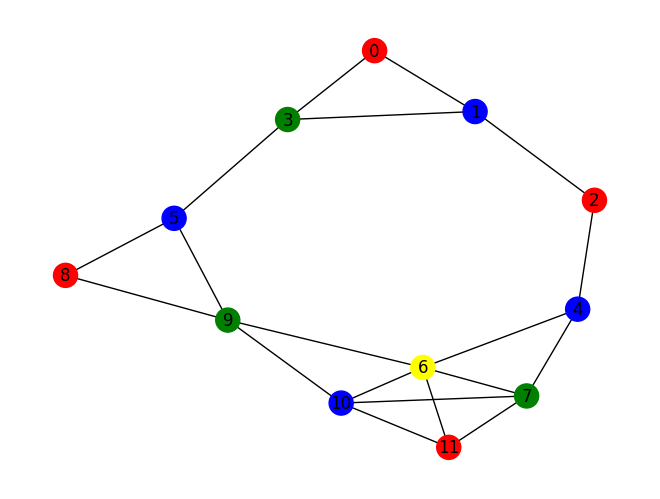

In [38]:
colors = ['red', 'blue', 'green', 'yellow', 'magenta', 'cyan', 'orange', 'purple']
color_counter=0
color_list = ['']*G.number_of_nodes()

# Assign colors
for l in portfolios:
    for node in l:
        color_list[node] = colors[color_counter]
    
    color_counter += 1

pos = nx.spring_layout(G, iterations=100, seed=42)
nx.draw(
   G,
   pos=pos,
   with_labels=True,
   node_color=color_list
)